In [0]:
# libraries

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import mlflow

import pandas as pd
from plotnine import *
import numpy as np
from hyperopt import fmin, hp, tpe, STATUS_OK, SparkTrials, Trials

In [0]:
# double check to make sure all columns are double type or string
deltaPath = "/delta/nb_airbnb" 
clean_nb = spark.read.format("delta").load(deltaPath)
display(clean_nb.printSchema()) 

root
-- host_is_superhost: string (nullable = true)
-- host_response_time: string (nullable = true)
-- host_response_rate: double (nullable = true)
-- host_acceptance_rate: double (nullable = true)
-- host_total_listings_count: double (nullable = true)
-- neighbourhood_cleansed: string (nullable = true)
-- latitude: double (nullable = true)
-- longitude: double (nullable = true)
-- room_type: string (nullable = true)
-- accommodates: double (nullable = true)
-- bedrooms: double (nullable = true)
-- beds: double (nullable = true)
-- minimum_nights: double (nullable = true)
-- availability_30: double (nullable = true)
-- availability_60: double (nullable = true)
-- availability_90: double (nullable = true)
-- availability_365: double (nullable = true)
-- number_of_reviews: double (nullable = true)
-- review_scores_rating: double (nullable = true)
-- review_scores_accuracy: double (nullable = true)
-- review_scores_cleanliness: double (nullable = true)
-- review_scores_checkin: double (nullable = true)
-- review_scores_communication: double (nullable = true)
-- review_scores_location: double (nullable = true)
-- review_scores_value: double (nullable = true)
-- reviews_per_month: double (nullable = true)
-- price: double (nullable = true)
-- bathrooms: double (nullable = true)
-- bedrooms_na: double (nullable = true)
-- bathrooms_na: double (nullable = true)
-- beds_na: double (nullable = true)
-- review_scores_rating_na: double (nullable = true)
-- review_scores_accuracy_na: double (nullable = true)
-- review_scores_cleanliness_na: double (nullable = true)
-- review_scores_checkin_na: double (nullable = true)
-- review_scores_communication_na: double (nullable = true)
-- review_scores_location_na: double (nullable = true)
-- review_scores_value_na: double (nullable = true)

In [0]:
clean_nb.count() # how many rows does my dataframe have

Out[3]: 2031

In [0]:
# lets drop lat / long

dropcol = ("latitude", "longitude","host_response_time")
final_nb = clean_nb.drop(*dropcol).cache()
display(final_nb)

host_is_superhost,host_response_rate,host_acceptance_rate,host_total_listings_count,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,price,bathrooms,bedrooms_na,bathrooms_na,beds_na,review_scores_rating_na,review_scores_accuracy_na,review_scores_cleanliness_na,review_scores_checkin_na,review_scores_communication_na,review_scores_location_na,review_scores_value_na
f,1.0,1.0,1.0,Saint Andrews,Entire home/apt,6.0,2.0,5.0,2.0,5.0,16.0,40.0,315.0,21.0,4.67,4.71,4.57,5.0,4.86,4.9,4.62,0.97,242.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f,1.0,0.33,1.0,Dundas,Entire home/apt,5.0,3.0,3.0,7.0,0.0,0.0,17.0,292.0,8.0,5.0,4.88,5.0,4.86,4.71,5.0,4.71,0.11,125.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f,1.0,1.0,2.0,City of Saint John,Entire home/apt,4.0,2.0,5.0,2.0,0.0,0.0,17.0,292.0,44.0,4.59,4.68,4.77,4.68,4.84,4.68,4.73,1.27,103.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f,1.0,0.67,1.0,Sackville,Private room,2.0,1.0,1.0,1.0,2.0,5.0,26.0,275.0,52.0,4.77,4.9,4.81,4.88,4.92,4.92,4.82,0.53,69.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f,null,0.0,1.0,Shippagan,Entire home/apt,6.0,2.0,2.0,7.0,0.0,0.0,0.0,261.0,3.0,4.67,3.67,4.67,4.67,4.67,4.67,4.33,0.13,135.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f,0.67,null,1.0,Cambridge,Entire home/apt,2.0,2.0,1.0,7.0,23.0,53.0,83.0,358.0,0.0,4.92,4.96,4.95,5.0,5.0,4.94,4.9,null,130.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
t,1.0,0.97,3.0,Moncton,Entire home/apt,7.0,3.0,4.0,3.0,7.0,22.0,49.0,323.0,192.0,4.88,4.92,4.86,4.94,4.95,4.79,4.86,2.27,138.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f,1.0,1.0,8.0,City of Saint John,Private room,2.0,1.0,1.0,1.0,25.0,55.0,85.0,360.0,126.0,4.58,4.63,4.83,4.65,4.67,4.67,4.64,1.71,145.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f,1.0,1.0,0.0,Gagetown,Entire home/apt,2.0,1.0,1.0,2.0,17.0,47.0,77.0,77.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,215.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
t,0.95,0.83,10.0,City of Saint John,Private room,2.0,1.0,1.0,1.0,0.0,0.0,0.0,80.0,39.0,4.84,4.95,4.79,4.89,4.92,4.82,4.84,0.54,125.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:



(trainDF, testDF) = final_nb.randomSplit([.8, .2], seed=42)

categoricalCols = [field for (field, dataType) in trainDF.dtypes if dataType == "string"]
indexOutputCols = [x + "Index" for x in categoricalCols]

stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=indexOutputCols, handleInvalid="skip")
#oheEncoder = OneHotEncoder(inputCols=indexOutputCols, outputCols=oheOutputCols)
numericCols = [field for (field, dataType) in trainDF.dtypes if ((dataType == "double") & (field != "price"))]
assemblerInputs = indexOutputCols + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features",handleInvalid='skip')




In [0]:
# HyperParameter tuning


# random froest model
rf = RandomForestRegressor(labelCol="price", featuresCol="features", maxBins = 128, seed = 42)



# evaluation statistic methods: MAE, RMSE

RMSE = RegressionEvaluator(
    labelCol=rf.getLabelCol(), predictionCol=rf.getPredictionCol(), metricName="rmse"
)

# will not be using this in the pipeline, but will still get the MAE for the model
MAE = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="diff",metricName="mae")




pipeline = Pipeline(stages=[stringIndexer, vecAssembler, rf])

regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price")

In [0]:
# for Hyper parameter tuning I need to know what paramters I can try to tune
print(rf.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto' (default: auto)
featuresCol: features column name. (default: features, current: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)
labelCol: label column name. (default: label, current: price)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature. (default: 32, current: 128)
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5)
maxMemoryInMB: Maximum memory in MB allocated to histogram aggregation. If too small, then 1 node will be split per iteration, and its aggregates may exceed this size. (default: 256)
minInfoGain: Minimum information gain for a split to be considered at a tree node. (default: 0.0)
minInstancesPerNode: Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1. (default: 1)
minWeightFractionPerNode: Minimum fraction of the weighted sample count that each child must have after split. If a split causes the fraction of the total weight in the left or right child to be less than minWeightFractionPerNode, the split will be discarded as invalid. Should be in interval [0.0, 0.5). (default: 0.0)
numTrees: Number of trees to train (>= 1). (default: 20)
predictionCol: prediction column name. (default: prediction)
seed: random seed. (default: 2502083311556356884, current: 42)
subsamplingRate: Fraction of the training data used for learning each decision tree, in range (0, 1]. (default: 1.0)
weightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)

In [0]:


def objective_function(params):    
  # set the hyperparameters that we want to tune
  max_depth = params["max_depth"]
  num_trees = params["num_trees"]
  # I can add more parameters

  # create a grid with our hyperparameters
  grid = (ParamGridBuilder()
    .addGrid(rf.maxDepth, [max_depth])
    .addGrid(rf.numTrees, [num_trees])
    .build())
  # If I have more parameters I can also add them in the grid object

  # cross validate the set of hyperparameters
  
  cv = CrossValidator(estimator=pipeline, evaluator=RMSE, estimatorParamMaps=grid, 
                    numFolds=5, parallelism=4, seed=42)
  cvModel = cv.fit(trainDF)

  # get our average RMSE across all three folds
  rmse = cvModel.avgMetrics[0]

  return {"loss": rmse, "status": STATUS_OK}

# really what I'm doing is: I'm finding the RMSE for the unique hyperparameter values that are being passed in, after I do cross validation for those sepeicic valeus

In [0]:


search_space = {
  "max_depth": hp.randint("max_depth", 2,9), # randint makes it between 2 and 9
  "num_trees": hp.randint("num_trees", 5, 10) # between 5 and 10
}

# the parameters should be set to higher numbers, it's low for now but will change

In [0]:

# Creating a parent run, meaning there will be other run's that happen underneath this one
with mlflow.start_run():
  num_evals = 5
  trials = Trials()
  best_hyperparam = fmin(fn=objective_function, 
                         space=search_space,
                         algo=tpe.suggest, # coming from hyperopt library
                         max_evals=num_evals,
                         trials=trials,
                         rstate=np.random.RandomState(42)
                        )
  
  # get optimal hyperparameter values
  best_max_depth = best_hyperparam["max_depth"] # get the best optimal parameter number for max depth
  best_num_trees = best_hyperparam["num_trees"]
  
  # change RF to use optimal hyperparameter values (this is a stateful method)
  rf.setMaxDepth(best_max_depth) # applies the optimal parameter we found above called "best_max_depth" and then applies this to the "rf" model
  rf.setNumTrees(best_num_trees)
  
  # train pipeline on entire training data - this will use the updated RF values
  pipelineModel = pipeline.fit(trainDF)
  
  # evaluate final model on test data
  predDF = pipelineModel.transform(testDF)
  rmse = regressionEvaluator.evaluate(predDF)
  
  # Log param and metric for the final model
  mlflow.log_param("max_depth", best_max_depth)
  mlflow.log_param("numTrees", best_num_trees)
  mlflow.log_metric("rmse", rmse)
 



0%| | 0/5 [00:00<?, ?trial/s, best loss=?] MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
 0%| | 0/5 [00:00<?, ?trial/s, best loss=?] 20%|██ | 1/5 [03:37<14:31, 217.96s/trial, best loss: 77.77807295144277] MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
 20%|██ | 1/5 [03:38<14:31, 217.96s/trial, best loss: 77.77807295144277] 40%|████ | 2/5 [05:52<08:27, 169.17s/trial, best loss: 77.2643281901125]  MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
 40%|████ | 2/5 [05:53<08:27, 169.17s/trial, best loss: 77.2643281901125] 60%|██████ | 3/5 [07:23<04:26, 133.41s/trial, best loss: 77.2643281901125] MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
 60%|██████ | 3/5 [07:24<04:26, 133.41s/trial, best loss: 77.2643281901125] 80%|████████ | 4/5 [09:12<02:03, 123.78s/trial, best loss: 77.2643281901125] MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
 80%|████████ | 4/5 [09:13<02:03, 123.78s/trial, best loss: 77.2643281901125]100%|██████████| 5/5 [11:03<00:00, 119.09s/trial, best loss: 77.2643281901125]100%|██████████| 5/5 [11:03<00:00, 132.72s/trial, best loss: 77.2643281901125]

In [0]:
from datetime import datetime
model_name = 'rf_trial_' + datetime.now().strftime('%Y_%d_%m_%H_%M')
pipelineModel.save(model_name)

In [0]:


# https://kb.databricks.com/machine-learning/extract-feature-info.html
def importance_plot(pipelineModel):
  va = pipelineModel.stages[-2]
  tree = pipelineModel.stages[-1] # use this if CV is not in pipeline
  # tree = pipelineModel.stages[-1].bestModel only use when cv is in model
  a = list(zip(va.getInputCols(), tree.featureImportances))
  dat_fi = pd.DataFrame({'variable': [i[0] for i in a], 'importance':[i[1] for i in a]}) \
    .sort_values('importance', ascending=False) \
    .assign(
      variable_cat = lambda x: pd.Categorical(x['variable'], categories = x.sort_values('importance', ascending=True)['variable']))

  plot = ggplot(dat_fi, aes(y = "importance", x = "variable_cat")) +\
    geom_col() +\
    coord_flip() +\
    theme_bw() +\
    labs(title = "Feature importance plot", x = "Feature")
  print(plot)
  return dat_fi

def model_results(predDF, labelCol = 'price', predictCol = 'prediction'):
  dat = predDF.select(labelCol, predictCol).toPandas()
  
  evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
  rmse = evaluator.evaluate(predDF)
  rmse = "RMSE data = %g" % rmse
  rsquared = "  R-squared:" + str(round(predDF.stat.corr('price', 'prediction'),2))

  
  p = ggplot(dat, aes(x = labelCol, y = predictCol)) +\
    geom_point() +\
    geom_abline(intercept=0, slope=1, color = "darkgrey") +\
    theme_bw() +\
    labs(title = "Predicted Vs. Actual: " +   rmse + rsquared)
  return p

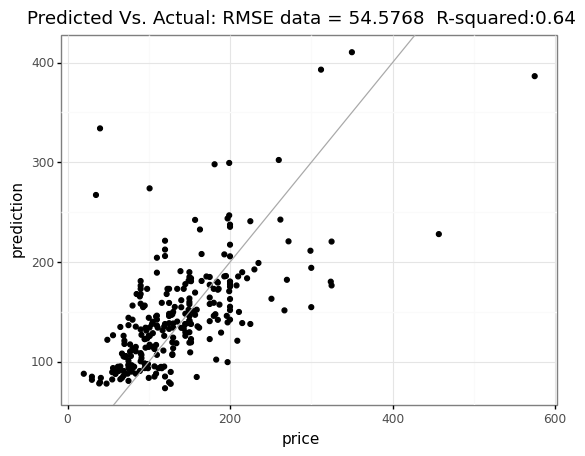

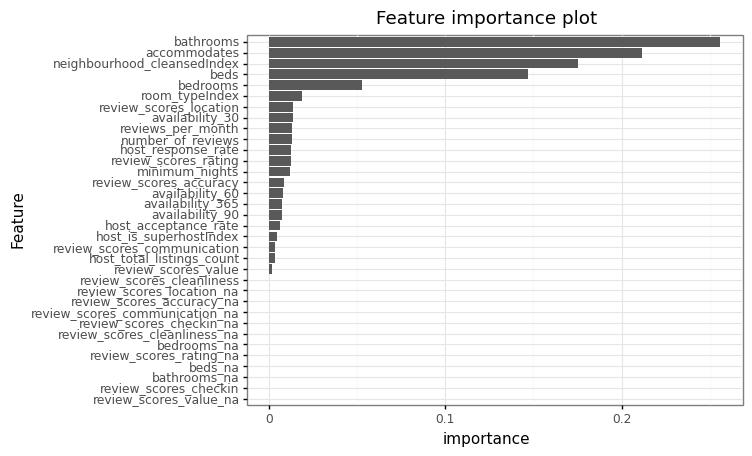

Out[13]:

,variable,importance,variable_cat
23,bathrooms,0.255887,bathrooms
6,accommodates,0.211626,accommodates
1,neighbourhood_cleansedIndex,0.175546,neighbourhood_cleansedIndex
8,beds,0.146860,beds
7,bedrooms,0.052891,bedrooms
2,room_typeIndex,0.018502,room_typeIndex
20,review_scores_location,0.013656,review_scores_location
10,availability_30,0.013312,availability_30
22,reviews_per_month,0.012983,reviews_per_month
14,number_of_reviews,0.012723,number_of_reviews


In [0]:
print(model_results(predDF))
importance_plot(pipelineModel)